# Notes

# Import Libraries

/opt/homebrew/Caskroom/miniforge/base/envs/torch-gpu/lib/python3.8/site-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/opt/homebrew/Caskroom/miniforge/base/envs/torch-gpu/lib/python3.8/site-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]           1,728
       BatchNorm2d-2           [-1, 64, 28, 28]             128
            Conv2d-3           [-1, 64, 28, 28]          36,864
       BatchNorm2d-4           [-1, 64, 28, 28]             128
            Conv2d-5           [-1, 64, 28, 28]          36,864
       BatchNorm2d-6           [-1, 64, 28, 28]             128
        BasicBlock-7           [-1, 64, 28, 28]               0
            Conv2d-8           [-1, 64, 28, 28]          36,864
       BatchNorm2d-9           [-1, 64, 28, 28]             128
           Conv2d-10           [-1, 64, 28, 28]          36,864
      BatchNorm2d-11           [-1, 64, 28, 28]             128
       BasicBlock-12           [-1, 64, 28, 28]               0
           Conv2d-13       

  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.21E+00


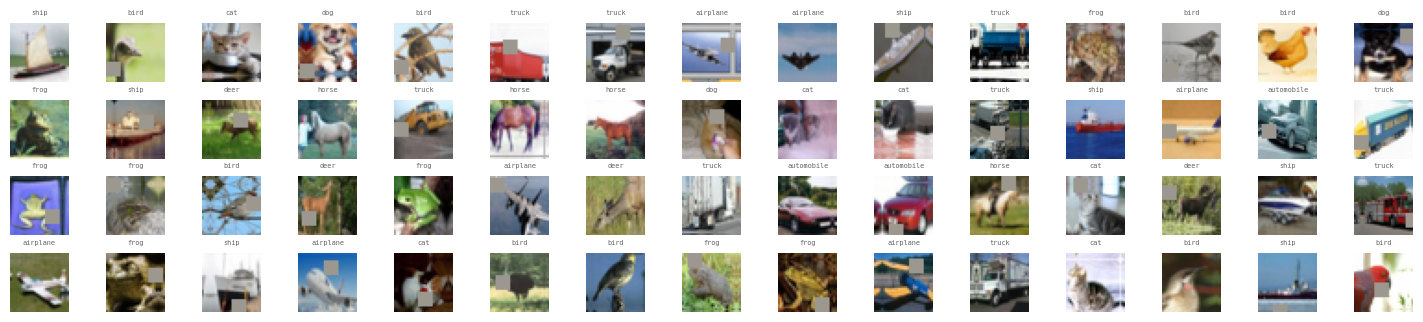

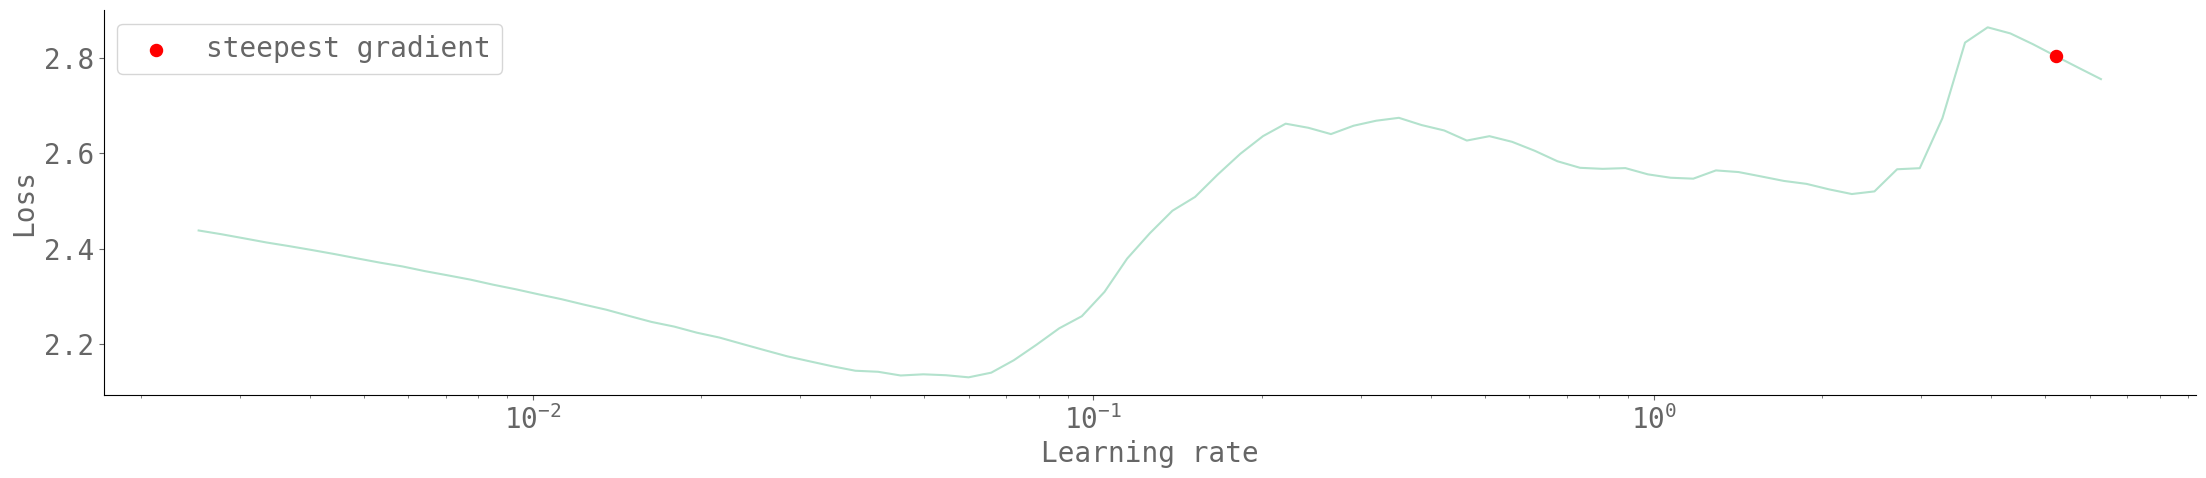

In [1]:
import utils
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
from data_loader import prepare_cifar_dataloader,\
    CIFAR_CLASS_LABELS
from utils import plot_misclassified_images
from torchsummary import summary
import model

## params
device = 'mps:0'
epochs = 3
batch_size = 126

train_loader, test_loader = prepare_cifar_dataloader()
utils.plot_img_batch(
    train_loader, CIFAR_CLASS_LABELS,
    ncols=15, nrows=4)

network = model.ResNet18()
print(model.summary_printer(network))
network.to(device)

optimizer = optim.SGD(network.parameters(), lr=0.001)

criterion = nn.CrossEntropyLoss()
suggested_lr = model.lr_finder(
    network, optimizer, criterion, device, train_loader)



In [3]:
epochs=20
scheduler = OneCycleLR(
    optimizer, max_lr=suggested_lr,
    steps_per_epoch=len(train_loader),
    epochs=epochs, 
    pct_start=5/epochs, 
    three_phase=False,
    div_factor=100,
    final_div_factor=100,
    anneal_strategy='linear',
)

for epoch in range(epochs):
    print("EPOCH:", epoch)
    model.train(network, device, train_loader, optimizer, scheduler)
    test_acc = model.test(network, device, test_loader)



EPOCH: 0


Loss=1.9657 Batch_id=68 LR=0.78050 Accuracy=23.85:  70%|███████   | 69/98 [00:49<00:20,  1.40it/s]

In [ ]:
from explainer import grad_cam
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

n_cam_images = 20
inputs, target = next(iter(train_loader))
input_tensor = inputs[:n_cam_images].to(device)
true_class = target[:n_cam_images]

cam_output = grad_cam(network, [network.layer3[-1]], input_tensor, true_class)

grid = make_grid(cam_output[:n_cam_images],
    nrow=10, padding=2, normalize=True)

# Convert the grid to a NumPy array
grid_np = grid.numpy().transpose((1, 2, 0))

# Plot the grid
plt.imshow(grid_np)
plt.axis('off')
plt.show()

RuntimeError: grad can be implicitly created only for scalar outputs

In [ ]:
model.plot_loss_n_acc()
labels_df = model.get_pred_n_actuals(network, test_loader, device)
plot_misclassified_images(labels_df, test_loader.dataset, 
        CIFAR_CLASS_LABELS, n_samples=20,
        nrows=2, ncols=10, figsize=(25,6),
        title='misclassified images (Pred | Target)', )

from metrics import get_metrics
get_metrics(labels_df, CIFAR_CLASS_LABELS)